In [1]:
# Connecting to clickhouse on remote server
import clickhouse_connect
clickhouse_client = clickhouse_connect.get_client(host='localhost')
clickhouse_client.command('SET max_threads = 8;')

In [2]:
import heapq
def moving_average(arr, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(arr, weights, mode='valid')

def get_throughput(series):
    W = 10
    arr = series.to_numpy()
    mv_avg = moving_average(arr, W)
    largest_numbers = heapq.nlargest(W, mv_avg)
    return sum(largest_numbers) / W

In [3]:
test_ids = [
    '31f73544dae74716ba3af75330d02301',
    'b2a8430073e847cc86b19f940bd96f30',
    'de390cac8de345d997e8376a7e36eb5f',
    '71cbc372fc174c1ea07389b2d30bd4a7'
]

In [4]:
import numpy as np
import pandas as pd
import pickle
import datetime

dataset = []
ignores = [-90, -70, -50, -39, -37, -35, -33, -31, -29, -27, -25, -23, -21, -19, -17, -15, -13.8, -13.4, -12.8, -12.4, -11.8, -11.4, -10.8, -10.4, -9.8, -9.4, -8.8, -8.4, -7.8, -7.4]
for test_id_idx, test_id in enumerate(test_ids):    
    print(f'------ Test ID {test_id}')
    query = f"""
        SELECT *
        FROM wgn
        WHERE test_id = '{test_id}' AND direction = 0
        ORDER BY timestamp
    """
    df_wgn =  clickhouse_client.query_df(query)
    # print(df_wgn)
    # noise = df_wgn['noise_level'].to_numpy()
    # print(noise)

    # Group by noise_level and get the start (min) and stop (max) timestamps
    df_noise_time_ranges = df_wgn.groupby('noise_level').agg(
        begin_time=('timestamp', 'min'),
        end_time=('timestamp', 'max'),
        max_throughput=('throughput_mbps', get_throughput),
    ).reset_index()
    df_noise_time_ranges = df_noise_time_ranges.sort_values('noise_level')
    # print(df_noise_time_ranges)

    for index_i, noise_record in df_noise_time_ranges.iterrows():
        if noise_record.noise_level in ignores:
            continue
        print(f" - Noise level {noise_record.noise_level} between {noise_record.begin_time} {noise_record.end_time}")

        while True:
            try:
                print("mac")
                query = f"""
                SELECT * FROM MAC_KPIs_2 
                WHERE TsTaiNs BETWEEN '{noise_record.begin_time}' AND '{noise_record.end_time}'
                ORDER BY TsTaiNs DESC
                """
                # print(query)
                df_mac = clickhouse_client.query_df(query)
                # print(df_mac)
        
                print("fapi")
                query = f"""
                SELECT * FROM fapi 
                WHERE TsTaiNs BETWEEN '{noise_record.begin_time}' AND '{noise_record.end_time}'
                ORDER BY TsTaiNs DESC
                """
                # print(query)
                df_fapi = clickhouse_client.query_df(query)
                # print(df_fapi)
                # After query
                df_fapi['index_TsTaiNs'] = df_fapi['TsTaiNs']  # Preserve original timestamps
                df_fapi.set_index('index_TsTaiNs', inplace=True)
                df_fapi = df_fapi.resample('1s').first()
                # print(df_fapi)
        
                print("fh")
                # Extract TsTaiNs values from df_fapi
                ts_tai_ns_values = df_fapi['TsTaiNs'].tolist()
                ts_tai_ns_values_str = ','.join(f"'{ts}'" for ts in ts_tai_ns_values)  # Format as SQL-compatible string
                # Build the query
                query = f"""
                SELECT TsTaiNs,fhData
                FROM fh
                WHERE TsTaiNs BETWEEN '{noise_record.begin_time}' AND '{noise_record.end_time}'
                  AND TsTaiNs IN ({ts_tai_ns_values_str})
                ORDER BY TsTaiNs DESC
                """
                # print(query)
                df_fh = clickhouse_client.query_df(query)
                # print(df_fh)
        
                data = {
                        'noise_level': noise_record.noise_level,
                        'throughput': noise_record.max_throughput,
                        'mac': df_mac,
                        'fapi': df_fapi,
                        'fh': df_fh,
                }
                dataset.append(data)
                break
            except Exception as e:
                print(e)
    #     break
    # break

------ Test ID 31f73544dae74716ba3af75330d02301
 - Noise level -100.0 between 2025-04-14 06:28:13 2025-04-14 06:35:28
mac
fapi
fh
 - Noise level -80.0 between 2025-04-14 06:43:16 2025-04-14 06:50:31
mac
fapi
fh
 - Noise level -60.0 between 2025-04-14 06:58:18 2025-04-14 07:05:33
mac
fapi
fh
 - Noise level -40.0 between 2025-04-14 07:13:21 2025-04-14 07:20:36
mac
fapi
fh
 - Noise level -38.0 between 2025-04-14 07:28:24 2025-04-14 07:35:39
mac
fapi
fh
 - Noise level -36.0 between 2025-04-14 07:43:27 2025-04-14 07:50:42
mac
fapi
fh
 - Noise level -34.0 between 2025-04-14 07:58:30 2025-04-14 08:05:45
mac
fapi
fh
 - Noise level -32.0 between 2025-04-14 08:13:33 2025-04-14 08:18:45
mac
fapi
fh
------ Test ID b2a8430073e847cc86b19f940bd96f30
 - Noise level -32.0 between 2025-04-14 08:25:30 2025-04-14 08:32:45
mac
fapi
fh
 - Noise level -30.0 between 2025-04-14 08:40:33 2025-04-14 08:47:47
mac
fapi
fh
 - Noise level -28.0 between 2025-04-14 08:55:35 2025-04-14 09:02:50
mac
fapi
fh
 - Noise lev

In [5]:
print(len(dataset))
print(data['fh'])

39
                   TsTaiNs                                             fhData
0  2025-04-14 15:27:16.417  [-0.03451538, -0.07867432, -0.019332886, 0.040...
1  2025-04-14 15:27:15.287  [0.03866577, 0.0013799667, -0.0013799667, 0.01...
2  2025-04-14 15:27:14.407  [-0.03173828, -0.05935669, -0.048309326, 0.053...
3  2025-04-14 15:27:13.187  [-0.1159668, 0.7011719, 0.022079468, -0.005519...
4  2025-04-14 15:27:12.127  [-0.48046875, 0.5576172, -0.0552063, 0.0, -0.5...
5  2025-04-14 15:27:11.027  [-0.06488037, -0.0027599335, -0.08831787, 0.03...
6  2025-04-14 15:27:10.407  [-0.019332886, -0.020706177, 0.020706177, -0.0...
7  2025-04-14 15:27:09.187  [-0.09661865, -0.10217285, -0.06347656, -0.038...
8  2025-04-14 15:27:08.197  [0.019332886, -0.017944336, -0.020706177, -0.1...
9  2025-04-14 15:27:07.117  [0.022079468, -0.03173828, 0.06210327, -0.0289...
10 2025-04-14 15:27:06.047  [-0.640625, 0.18225098, -0.046936035, -0.07452...
11 2025-04-14 15:27:05.007  [-0.013801575, -0.08557129, -0.00

In [6]:
# with open(f'dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
def comparator(a, b):
    # Example: case-insensitive string comparison
    return a['noise_level'] == b['noise_level']

def remove_first_appearance_of_duplicates(lst, comparator):
    to_remove_indices = set()
    length = len(lst)

    for i in range(length):
        for j in range(i + 1, length):
            if comparator(lst[i], lst[j]):
                to_remove_indices.add(i)  # mark first appearance
                break

    # Remove in reverse to avoid index shift
    for index in sorted(to_remove_indices, reverse=True):
        del lst[index]
    
    return lst

remove_first_appearance_of_duplicates(dataset, comparator)
print(len(dataset))

37


In [8]:
# dataset_new = [data if data['noise_level'] < -8 for data in dataset]

In [9]:
# df_noise_time_throughputs = pd.DataFrame()
# for test_id_idx, test_id in enumerate(test_ids):
#     print(f'------ Test ID {test_id}')
#     query = f"""
#         SELECT *
#         FROM wgn
#         WHERE test_id = '{test_id}' AND direction = 0
#         ORDER BY timestamp
#     """
#     df_wgn_2 =  clickhouse_client.query_df(query)
#     # print(df_wgn)
#     # noise = df_wgn['noise_level'].to_numpy()
#     # print(noise)

#     # Group by noise_level and get the start (min) and stop (max) timestamps
#     df_noise_time_ranges_2 = df_wgn_2.groupby('noise_level').agg(
#         begin_time=('timestamp', 'min'),
#         end_time=('timestamp', 'max'),
#         max_throughput=('throughput_mbps', get_throughput)
#     ).reset_index()
#     df_noise_time_throughput = df_noise_time_ranges_2.sort_values('noise_level')
#     df_noise_time_throughputs = pd.concat([df_noise_time_throughputs, df_noise_time_throughput], axis=0, ignore_index=False)
# print(df_noise_time_throughputs)

In [46]:
import matplotlib.pyplot as plt

Ys = []
Xs_mac = []
Xs_iq = []
for data in dataset:
    noise_level = data['noise_level']
    throughput = data['throughput']
    df_mac = data['mac']
    df_fapi = data['fapi']
    df_fh = data['fh']
    for index_fapi, fapi_record in df_fapi.iterrows():
        # print(f"FAPI {index_fapi}")
        TsTaiNs = fapi_record.TsTaiNs

        matching_mac = df_mac[df_mac['TsTaiNs'] <= TsTaiNs]
        # print(len(matching_mac))
        if len(matching_mac) < 20:
            continue
        # print(matching_mac)

        # Sort by TsTaiNs in descending order and get the 10 latest records
        matching_mac = matching_mac.sort_values(by='TsTaiNs', ascending=False).head(20)
        # matching_mac = matching_mac[['phr', 'wb_cqi_1tb', 'pusch_snr', 'rsrp']].to_numpy() / np.array([100, 20, 30, -150])
        matching_mac = matching_mac[['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 'ul_harq_2', 'ul_harq_3']].to_numpy()
        # print(matching_mac.shape)
        # print(matching_mac)
        
        matching_fh = df_fh[df_fh['TsTaiNs'] == TsTaiNs]
        # print(len(matching_fh))
        if len(matching_fh) != 1:
            continue
        # print(matching_fh)

        fh_samp = np.array(matching_fh['fhData'].iloc[0], dtype=np.float32)
        rx_slot = np.swapaxes(fh_samp.view(np.complex64).reshape(4, 14, 273*12), 2, 0)[:,:,0]
        # print(rx_slot)
        # print(rx_slot.shape)

        rx_slot[fapi_record.rbStart: fapi_record.rbSize * 12, fapi_record.StartSymbolIndex : fapi_record.NrOfSymbols] = 0
        I = np.real(rx_slot)  # Real part
        Q = np.imag(rx_slot)  # Imaginary part
        IQ_tensor = np.stack([I, Q], axis=0)
        # print(IQ_tensor.shape)

        # fig, axs = plt.subplots(1)
        # axs.imshow(10*np.log10(np.abs(rx_slot**2)), aspect='auto')
        # axs.set_ylim([0, 273 * 12])
        # axs.set_xlim([0, 14])
        # axs.set_title('Ant ' + str(0))
        # axs.set(xlabel='Symbol', ylabel='Resource Element')
        # axs.label_outer()
        # fig.suptitle('Power in RU Antennas') 
        # plt.show(fig)

        Ys.append(throughput)
        Xs_mac.append(matching_mac)
        Xs_iq.append(IQ_tensor)

    #     break
    # break

# print(Ys)
# print(Xs)
print(len(Ys))
print(len(Xs_mac))

print(len(Xs_iq))

15988
15988
15988


In [47]:
import torch
X_mac_torch = torch.tensor(Xs_mac, dtype=torch.float32)
print(X_mac_torch.shape)
X_iq_torch = torch.tensor(Xs_iq, dtype=torch.float32)
print(X_iq_torch.shape)
y_torch = torch.tensor(Ys, dtype=torch.float32)
print(y_torch.shape)

torch.Size([15988, 20, 14])
torch.Size([15988, 2, 3276, 14])
torch.Size([15988])


In [48]:
import torch
import torch.nn as nn
# !pip install torchinfo
from torchinfo import summary

class ThroughputEstimator(nn.Module):
    """LSTM and CNN unit for regression"""

    def __init__(self, lstm_input_size, output_size, hidden_size, num_layers, model_type, drop_out=0.1):
        super().__init__()

        self.lstm_input_size = lstm_input_size  # Number of features per time step for LSTM
        self.hidden_size = hidden_size  # Size of hidden state
        self.output_size = output_size  # Number of output features
        self.num_layers = num_layers    # Number of LSTM layers
        self.drop_out = drop_out        # Dropout probability

        self.model_type = model_type

        if self.model_type == 1 or self.model_type == 3:
            # LSTM: Processes input of shape (batch_size, seq_len, lstm_input_size)
            self.lstm = nn.LSTM(
                input_size=self.lstm_input_size,  # Fixed: Changed from self.input_size to self.lstm_input_size
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,           # Input shape: (batch_size, seq_len, lstm_input_size)
                dropout=self.drop_out if self.num_layers > 1 else 0.0,  # Dropout only if >1 layer
            )

        if self.model_type == 2 or self.model_type == 3:
            # CNN: Processes input of shape (batch_size, cnn_in_channels, 3276, 14)
            self.cnn = nn.Sequential(
                nn.Conv2d(
                    in_channels=2,  # Assuming cnn_in_channels=2 as in original code
                    out_channels=16,
                    kernel_size=3,
                    stride=1,
                    padding=1
                ),  # Output: (batch_size, 16, 3276, 14)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 16, 1638, 7)
                nn.Conv2d(
                    in_channels=16,
                    out_channels=32,
                    kernel_size=3,
                    stride=1,
                    padding=1
                ),  # Output: (batch_size, 32, 1638, 7)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 32, 819, 3)
                nn.Flatten(),  # Output: (batch_size, 32 * 819 * 3)
                nn.Linear(32 * 819 * 3, self.hidden_size),  # Output: (batch_size, hidden_size)
                nn.ReLU(),
                nn.Dropout(self.drop_out)
            )

        if self.model_type == 1 or self.model_type == 2:
            # Final FC layer: Combines CNN and LSTM outputs
            self.fc = nn.Sequential(
                nn.Linear(self.hidden_size, self.output_size),
                # nn.Dropout(self.drop_out) if self.drop_out > 0 else nn.Identity()
            )
        elif self.model_type == 3:
            # Final FC layer: Combines CNN and LSTM outputs
            self.fc = nn.Sequential(
                nn.Linear(self.hidden_size * 2, self.output_size),  # Combines CNN (hidden_size) + LSTM (hidden_size)
                nn.Dropout(self.drop_out) if self.drop_out > 0 else nn.Identity()
            )

    def forward(self, lstm_input, cnn_input):
        """
        Args:
            cnn_input: Tensor of shape (batch_size, cnn_in_channels, 3276, 14)
            lstm_input: Tensor of shape (batch_size, seq_len, lstm_input_size)
        Returns:
            Tensor of shape (batch_size,) if output_size=1, else (batch_size, output_size)
        """
        if self.model_type == 1 or self.model_type == 3:
            # LSTM forward pass
            h0 = torch.zeros(self.num_layers, lstm_input.size(0), self.hidden_size).to(lstm_input.device)
            c0 = torch.zeros(self.num_layers, lstm_input.size(0), self.hidden_size).to(lstm_input.device)
            lstm_out, _ = self.lstm(lstm_input, (h0, c0))  # Shape: (batch_size, seq_len, hidden_size)
            lstm_out = lstm_out[:, -1, :]  # Take last time step: (batch_size, hidden_size)
        
        if self.model_type == 2 or self.model_type == 3:
            # CNN forward pass
            cnn_out = self.cnn(cnn_input)  # Shape: (batch_size, hidden_size)

        if self.model_type == 3:
            # Combine CNN and LSTM outputs
            combined = torch.cat((cnn_out, lstm_out), dim=1)  # Shape: (batch_size, hidden_size * 2)

        if self.model_type == 1:
            out = self.fc(lstm_out)
        elif self.model_type == 2:
            out = self.fc(cnn_out)
        elif self.model_type == 3:
            # Final FC layer
            out = self.fc(combined)  # Shape: (batch_size, output_size)
        
        # Squeeze if output_size == 1
        return out.squeeze(-1) if self.output_size == 1 else out

In [49]:
import dill
lstm_only_model = ThroughputEstimator(14, 1, 50, 1, 1)
cnn_only_model = ThroughputEstimator(14, 1, 50, 1, 2)
combined_model = ThroughputEstimator(14, 1, 50, 1, 3)
model_stats = summary(lstm_only_model)
print(model_stats)
model_stats = summary(cnn_only_model)
print(model_stats)
model_stats = summary(combined_model)
print(model_stats)

Layer (type:depth-idx)                   Param #
ThroughputEstimator                      --
├─LSTM: 1-1                              13,200
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       51
│    └─Dropout: 2-2                      --
Total params: 13,251
Trainable params: 13,251
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
ThroughputEstimator                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       304
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       4,640
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       3,931,250
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
├─Sequential: 1-2                        --
│    └─Linear: 2-11      

In [50]:
# Check for GPU availability
print(f"Number of GPUs available: {torch.cuda.device_count()}")

# Set device dynamically
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming models are defined, move them to the device
try:
    lstm_only_model.to(device)
    cnn_only_model.to(device)
    combined_model.to(device)
    print("Models moved to device successfully.")
except NameError as e:
    print(f"Error: One or more models are not defined - {e}")
# model.train(True)

def check_model_device(model, model_name):
    for name, param in model.named_parameters():
        print(f"{model_name} parameter '{name}' is on device: {param.device}")

check_model_device(lstm_only_model, "lstm_only_model")
check_model_device(cnn_only_model, "cnn_only_model")
check_model_device(combined_model, "combined_model")

Number of GPUs available: 1
Using device: cuda:0
Models moved to device successfully.
lstm_only_model parameter 'lstm.weight_ih_l0' is on device: cuda:0
lstm_only_model parameter 'lstm.weight_hh_l0' is on device: cuda:0
lstm_only_model parameter 'lstm.bias_ih_l0' is on device: cuda:0
lstm_only_model parameter 'lstm.bias_hh_l0' is on device: cuda:0
lstm_only_model parameter 'fc.0.weight' is on device: cuda:0
lstm_only_model parameter 'fc.0.bias' is on device: cuda:0
cnn_only_model parameter 'cnn.0.weight' is on device: cuda:0
cnn_only_model parameter 'cnn.0.bias' is on device: cuda:0
cnn_only_model parameter 'cnn.3.weight' is on device: cuda:0
cnn_only_model parameter 'cnn.3.bias' is on device: cuda:0
cnn_only_model parameter 'cnn.7.weight' is on device: cuda:0
cnn_only_model parameter 'cnn.7.bias' is on device: cuda:0
cnn_only_model parameter 'fc.0.weight' is on device: cuda:0
cnn_only_model parameter 'fc.0.bias' is on device: cuda:0
combined_model parameter 'lstm.weight_ih_l0' is on d

In [57]:
lstm_criterion = nn.MSELoss()
cnn_criterion = nn.MSELoss()
combined_criterion = nn.MSELoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.05)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=0.000005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.0000005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00000001, weight_decay=0.00000005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.00005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000001, weight_decay=0.000005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000000001, weight_decay=0.00000005)

lstm_optimizer = torch.optim.Adam(lstm_only_model.parameters(), lr=0.01, weight_decay=0.05)
cnn_optimizer = torch.optim.Adam(cnn_only_model.parameters(), lr=0.0001, weight_decay=0.0005)
combined_optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.0001, weight_decay=0.0005)

In [58]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, random_split

# Wrap in TensorDataset
# tdataset = TensorDataset(X_mac_torch, X_iq_torch, y_torch)
tdataset = TensorDataset(X_mac_torch, y_torch)

# Create DataLoader
# train_data = DataLoader(tdataset, batch_size=2**14, shuffle=True, drop_last=False)
# print(len(train_data))

# # Define the split ratio
# train_ratio = 0.8  # 80% for training
# test_ratio = 0.2   # 20% for testing

# # Calculate the number of samples for each split
# total_size = len(tdataset)
# train_size = int(train_ratio * total_size)
# test_size = total_size - train_size  # Ensures all samples are used

# # Perform the train-test split
# train_dataset, test_dataset = random_split(tdataset, [train_size, test_size])

from torch.utils.data import Subset
import numpy as np

# Set fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Size setup
dataset_size = len(tdataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Generate a random permutation of indices
indices = torch.randperm(dataset_size).tolist()

# Split indices
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create Subsets
train_dataset = Subset(tdataset, train_indices)
test_dataset = Subset(tdataset, test_indices)

train_data = DataLoader(
    train_dataset,
    batch_size=2**16,
    shuffle=True,
    drop_last=False
)

test_data = DataLoader(
    test_dataset,
    batch_size=2**10,  # 1024 (example; adjust based on memory constraints)
    shuffle=False,     # No shuffling for evaluation
    drop_last=False
)

In [59]:
# del Xs_mac
# del Xs_iq
# del Ys
# del X_mac_torch
# del X_iq_torch
# del y_torch

In [60]:
# Training loop
num_epochs = 100

lstm_only_model.train()
cnn_only_model.train()
combined_model.train()

for epoch in range(num_epochs):
    # print(f'Begin of epoch {epoch}')
    lstm_train_loss = 0
    cnn_train_loss = 0
    combined_train_loss =0

    # for i, (batch_mac, batch_y) in enumerate(train_data, 0):
    for i, (batch_mac, batch_iq, batch_y) in enumerate(train_data, 0):
        # print(f'Start of batch {i}')
        batch_mac = batch_mac.to(device)
        # batch_iq = batch_iq.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        lstm_outputs = lstm_only_model(batch_mac, None)
        lstm_loss = lstm_criterion(lstm_outputs, batch_y)
        # Backward pass
        lstm_optimizer.zero_grad()
        lstm_loss.backward()
        lstm_optimizer.step()
        lstm_train_loss += lstm_loss.item() * batch_y.size(0)

        # Forward pass
        cnn_outputs = cnn_only_model(None, batch_iq)
        cnn_loss = cnn_criterion(cnn_outputs, batch_y)
        # Backward pass
        cnn_optimizer.zero_grad()
        cnn_loss.backward()
        cnn_optimizer.step()
        cnn_train_loss += cnn_loss.item() * batch_y.size(0)

        # Forward pass
        combined_outputs = combined_model(batch_mac, batch_iq)
        combined_loss = combined_criterion(combined_outputs, batch_y)
        # Backward pass
        combined_optimizer.zero_grad()
        combined_loss.backward()
        combined_optimizer.step()
        combined_train_loss += combined_loss.item() * batch_y.size(0)
        # print(f'End of batch {i}')
        
    lstm_train_loss = lstm_train_loss / len(train_dataset)
    cnn_train_loss = cnn_train_loss / len(train_dataset)
    combined_train_loss = combined_train_loss / len(train_dataset)
    print(f'End of epoch {epoch}')
    print(f'Epoch [{epoch + 1}/{num_epochs}], lstm_train_loss: {lstm_train_loss:.4f} cnn_train_loss: {cnn_train_loss:.4f} combined_train_loss: {combined_train_loss:.4f}')
    # if (epoch + 1) % 10 == 0:
    #     print(f'Epoch [{epoch + 1}/{num_epochs}], lstm_train_loss: {lstm_train_loss:.4f}')

ValueError: not enough values to unpack (expected 3, got 2)

LSTM Only - Test set size: 3198 samples
LSTM Only Metrics:
  R² Score: -0.5987
  MAE: 14.1263
  MSE: 339.6953



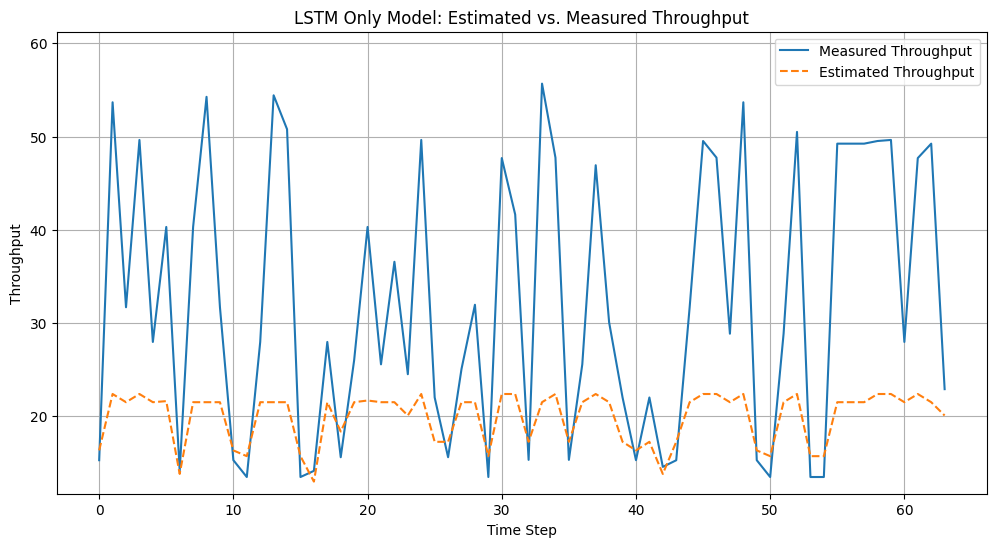

Summary of Metrics:
LSTM Only:
  R²: -0.5987, MAE: 14.1263, MSE: 339.6953


In [55]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# List of models to evaluate
models = {
    'LSTM Only': lstm_only_model,
    # 'CNN Only': cnn_only_model,
    # 'Combined': combined_model
}

# Dictionary to store metrics for each model
metrics = {
    'LSTM Only': {'r2': 0, 'mae': 0, 'mse': 0},
    # 'CNN Only': {'r2': 0, 'mae': 0, 'mse': 0},
    # 'Combined': {'r2': 0, 'mae': 0, 'mse': 0}
}

# test_data = DataLoader(
#     tdataset,           # Your dataset containing (X_mac, X_iq, y)
#     batch_size=2**10,   # 1024 items per batch
#     shuffle=False,      # Keeps data in original order (important for evaluation/metrics)
#     drop_last=False     # Keeps the final batch even if it has fewer than 1024 items
# )

# Evaluate each model
for model_name, model in models.items():
    model.eval()
    y, p = [], []  # Lists to store ground truth and predictions

    with torch.no_grad():  # Disable gradient computation
        for i, (batch_mac, batch_y) in enumerate(test_data, 0):
        # for i, (batch_mac, batch_iq, batch_y) in enumerate(test_data, 0):
            # Move to device
            batch_mac = batch_mac.to(device)
            # batch_iq = batch_iq.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            if model_name == 'LSTM Only':
                outputs = model(batch_mac, None)  # LSTM uses batch_mac only
            elif model_name == 'CNN Only':
                outputs = model(None, batch_iq)  # CNN uses batch_iq only
            else:  # Combined model
                outputs = model(batch_mac, batch_iq)

            predicted = outputs.cpu().numpy().squeeze()  # Handle shape
            targets = batch_y.cpu().numpy().squeeze()

            # Collect data
            y.extend(targets)
            p.extend(predicted)

    # Convert to arrays
    y = np.array(y)
    p = np.array(p)

    # Verify lengths
    assert len(y) == len(p), f"Length mismatch for {model_name}: y={len(y)}, p={len(p)}"
    print(f"{model_name} - Test set size: {len(y)} samples")

    # Compute metrics
    r2 = r2_score(y, p)
    mae = mean_absolute_error(y, p)
    mse = mean_squared_error(y, p)
    
    # Store metrics
    metrics[model_name]['r2'] = r2
    metrics[model_name]['mae'] = mae
    metrics[model_name]['mse'] = mse

    print(f"{model_name} Metrics:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}\n")

    # Subsample for plotting
    step = 50  # Adjusted for more detail
    y_sub = y[::step]
    p_sub = p[::step]
    time_steps = np.arange(len(y_sub))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, y_sub, label='Measured Throughput')
    plt.plot(time_steps, p_sub, label='Estimated Throughput', linestyle='--')
    plt.title(f'{model_name} Model: Estimated vs. Measured Throughput')
    plt.xlabel('Time Step')
    plt.ylabel('Throughput')
    # Dynamic y-axis limits with 10% padding
    y_min = min(np.min(y_sub), np.min(p_sub))
    y_max = max(np.max(y_sub), np.max(p_sub))
    plt.ylim(y_min * 1.1 if y_min < 0 else y_min * 0.9, y_max * 1.1)
    plt.legend()
    plt.grid(True)
    plt.show()

# Print summary of metrics
print("Summary of Metrics:")
for model_name, metric in metrics.items():
    print(f"{model_name}:")
    print(f"  R²: {metric['r2']:.4f}, MAE: {metric['mae']:.4f}, MSE: {metric['mse']:.4f}")

In [56]:
torch.save(lstm_only_model, "lstm_only_model.pth", pickle_module=dill)
torch.save(cnn_only_model, "cnn_only_model.pth", pickle_module=dill)
torch.save(combined_model, "combined_model.pth", pickle_module=dill)